In [1]:
# Project data is downloaded from S&P Capital IQ Pro power generation asset screener
# All generation resources are included in the download, with reporting metrics as of 2019 to avoid implications of COVID 19 
# The goal of our project is to estimate emissions data using variables such as year of contruction, fuel and technology type, heat rate, and reglatory status. 

In [2]:
#-------------------------------------
#Profiling and getting the data ready
#-------------------------------------

In [3]:
get_ipython().ast_node_interactivity = 'all'

In [4]:

import pandas
from skimpy import clean_columns
# this is used to clean the messy column names
df = pandas.read_excel( "UpdatedProjectData.xlsx" )
df = clean_columns(df)
#import and clean data
#df.columns.tolist()
df = df[pandas.to_numeric(df['heat_rate'], errors='coerce').notnull()]
# heat rate is imorted as an object due to missing values "NM". This ereases those values as a missing heat rate means the asset isnt generating
df['heat_rate'] = df['heat_rate'].astype(float)
# Changes object to float
df['CO2_rate'] = df['co_2_emissions_rate_x_000_d_lb_mm_btu']
df['NOX_rate'] = df['nox_emissions_rate_x_000_d_lb_mm_btu']
df['SO2_rate'] = df['so_2_emissions_rate_x_000_d_lb_mm_btu']
# Cleaning these columns didnt quite get them easy to work with, so renamed manually
del df['co_2_emissions_rate_x_000_d_lb_mm_btu']
del df['nox_emissions_rate_x_000_d_lb_mm_btu']
del df['so_2_emissions_rate_x_000_d_lb_mm_btu']
df.dtypes
# check the rest of the column names and types

15 column names have been cleaned

power_plant                      object
plant_key                         int64
operating_status                 object
regulatory_status                object
installed_nameplate_capacity    float64
net_generation                  float64
heat_rate                       float64
capacity_factor                 float64
fuel_type                        object
technology_type                  object
year_first_unit_in_service      float64
avg_employees_x_000_d_actual    float64
CO2_rate                        float64
NOX_rate                        float64
SO2_rate                        float64
dtype: object

In [5]:
df = df.query( "(CO2_rate >0 ) & (NOX_rate > 0 ) & (SO2_rate > 0) & (heat_rate > 0) " )
# This removes all non-emtting resources such as solar and wind. These are not relevent for this project. 

In [6]:
df.describe()
#Most columns have far outliers to be aware of. Most assets do not have data on employee count. 

,plant_key,installed_nameplate_capacity,net_generation,heat_rate,capacity_factor,year_first_unit_in_service,avg_employees_x_000_d_actual,CO2_rate,NOX_rate,SO2_rate
count,1292.000000,1292.000000,1.292000e+03,1292.000000,1292.000000,1292.000000,444.000000,1292.000000,1292.000000,1292.000000
mean,4870.126161,591.704954,1.881567e+06,10960.984520,29.699613,1990.285604,55.047297,138.383783,0.086496,0.048543
std,4585.385712,566.259907,2.740321e+06,3951.197489,26.866818,19.178755,76.729862,36.731876,0.113436,0.143209
min,1.000000,25.000000,4.000000e+00,4661.000000,0.000439,1925.000000,0.000000,27.063900,0.002400,0.000100
25%,1295.000000,154.200000,8.036450e+04,8247.750000,4.498013,1974.000000,3.000000,118.857100,0.014875,0.000600
50%,3848.500000,438.500000,5.652750e+05,10707.500000,20.758220,1999.000000,29.000000,118.859850,0.045500,0.000600
75%,6838.250000,807.425000,2.828087e+06,12115.250000,53.687854,2003.000000,67.000000,124.043875,0.115250,0.005375
max,25015.000000,4263.000000,2.148600e+07,48180.000000,97.097847,2019.000000,425.000000,245.746500,1.200100,2.651100


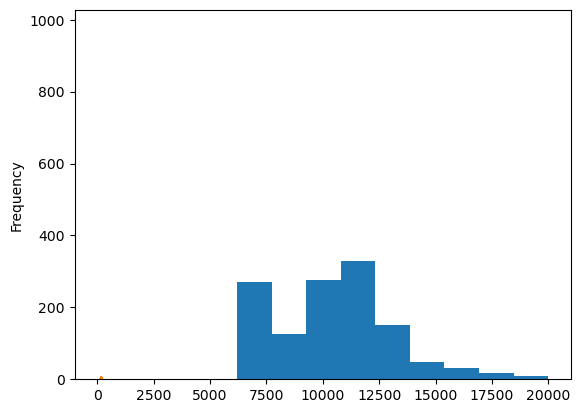

In [7]:
heat_rate_hist=df.query("(heat_rate < 20000 )")[ 'heat_rate' ].plot.hist()
CO2_hist=df[ 'CO2_rate' ].plot.hist()
NOX_hist=df.query("( NOX_rate < .5 )")['NOX_rate'].plot.hist()
SO2_hist=df.query("( SO2_rate < .0013 )")['SO2_rate'].plot.hist(bins = 25)
# visuaization of heat rates. 20,000 marked as upper bound as >75% of data falls below  12,115
# The heat rate is the amount of energy (Btu) used by an electrical generator/power plant to generate one kilowatthour (kWh) of electricity.

In [8]:
df.isna().sum()
# most plants missing employee counts

power_plant                       0
plant_key                         0
operating_status                  0
regulatory_status                 0
installed_nameplate_capacity      0
net_generation                    0
heat_rate                         0
capacity_factor                   0
fuel_type                         0
technology_type                   0
year_first_unit_in_service        0
avg_employees_x_000_d_actual    848
CO2_rate                          0
NOX_rate                          0
SO2_rate                          0
dtype: int64

In [9]:
df.technology_type.value_counts()

Combined Cycle             448
Gas Turbine                437
Steam Turbine              405
Integrated Gasification      2
Name: technology_type, dtype: int64

In [10]:
df.fuel_type.value_counts()

Gas                   997
Coal                  251
Oil                    29
Biomass                13
Other Nonrenewable      2
Name: fuel_type, dtype: int64

In [11]:
df.operating_status.value_counts()

Operating              1204
Retired                  72
Operating & Planned      12
Out of Service            2
Mothballed                2
Name: operating_status, dtype: int64

In [12]:
df.regulatory_status.value_counts()
# Status of a plant with regard to its owner's rate base being regulated by the state Public Utility Commission
# or municipal rate-setting authority. If any owned portion of a plant is regulated, the entire plant and its units are marked regulated.

Merchant Unregulated    694
Regulated               598
Name: regulatory_status, dtype: int64

In [13]:
import numpy
df['CO2_rating'] = numpy.where(df['CO2_rate']>df["CO2_rate"].median(), "High", "Low")
df['SO2_rating'] = numpy.where(df['CO2_rate']>df["SO2_rate"].median(), "High", "Low")
df['NOX_rating'] = numpy.where(df['CO2_rate']>df["NOX_rate"].median(), "High", "Low")
# Add column that will indicate if a plant is above or below average for a specifc type of emissions 

In [14]:
rng = numpy.random.RandomState( 28 )
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split( df, df.CO2_rating, random_state=rng, test_size=0.5 )
# The following models will be based on carbon dioxide emissions

In [15]:
lstNum = [ 'installed_nameplate_capacity', 'heat_rate', 'capacity_factor', 'year_first_unit_in_service']
lstCat = [ 'regulatory_status' , 'technology_type' , 'fuel_type',  ]

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
pipeNum = Pipeline( [
    ('selector', ColumnTransformer([ ('selector', 'passthrough', lstNum ) ] )),
    ('scaler', StandardScaler() )
])

In [17]:
from sklearn.preprocessing import OneHotEncoder
pipeCat = Pipeline([
    ('selector', ColumnTransformer([ ('selector', 'passthrough', lstCat ) ] )),
    ('encoder', OneHotEncoder( dtype=int, drop='first' ) )
])

In [18]:
from sklearn.pipeline import FeatureUnion
preprocessor = FeatureUnion([
    ('cat', pipeCat ),
    ('num', pipeNum )
])

In [19]:
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([
    ('preprocessor', preprocessor ),
    ('model', LogisticRegression( max_iter = 200 ) )
    ])

In [20]:
pipe.fit( X_train, y_train )

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selector',
                                                                                                   'passthrough',
                                                                                                   ['regulatory_status',
                                                                                                    'technology_type',
                                                                                                    'fuel_type'])])),
                                                                 ('encoder',
                                                                  OneHotEncoder(drop='first',
                                                                                dtype=<class 'int'>))])),
                                                ('num',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selector',
                                                                                                   'passthrough',
                                                                                                   ['installed_nameplate_capacity',
                                                                                                    'heat_rate',
                                                                                                    'capacity_factor',
                                                                                                    'year_first_unit_in_service'])])),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('model', LogisticRegression(max_iter=200))])

In [21]:
import sklearn.metrics
predTrain = pipe.predict( X_train )
predTest = pipe.predict( X_test )

In [22]:
pandas.value_counts( y_train )
pandas.value_counts( predTrain )

High    324
Low     322
Name: CO2_rating, dtype: int64

Low     342
High    304
dtype: int64

In [23]:
sklearn.metrics.confusion_matrix( y_train, predTrain )

array([[236,  88],
       [ 68, 254]], dtype=int64)

In [24]:
sklearn.metrics.accuracy_score( y_train, predTrain )
sklearn.metrics.cohen_kappa_score( y_train, predTrain )

0.7585139318885449

0.5171158048069919

In [25]:
sklearn.metrics.accuracy_score( y_test, predTest )
sklearn.metrics.cohen_kappa_score( y_test, predTest )

0.7461300309597523

0.49216757741347905

In [26]:
print( sklearn.metrics.classification_report( y_train, predTrain ) )

              precision    recall  f1-score   support

        High       0.78      0.73      0.75       324
         Low       0.74      0.79      0.77       322

    accuracy                           0.76       646
   macro avg       0.76      0.76      0.76       646
weighted avg       0.76      0.76      0.76       646



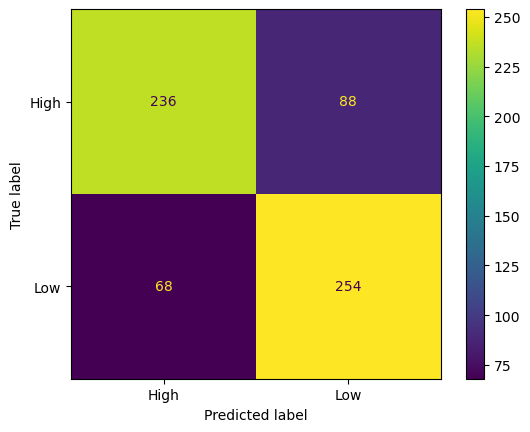

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
cmLogistic = sklearn.metrics.confusion_matrix( y_train, predTrain )
plotCmLogistic = sklearn.metrics.ConfusionMatrixDisplay( cmLogistic, display_labels=pipe.classes_ ).plot()

In [28]:
from sklearn.neural_network import MLPClassifier
pipeNn55 = Pipeline([
    ('preprocessor', preprocessor ),
    ('model', MLPClassifier(hidden_layer_sizes=(50,50), random_state = 28, max_iter=2000))  
], verbose = True)

In [29]:
pipeNn55.fit( X_train, y_train )

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   7.5s


Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selector',
                                                                                                   'passthrough',
                                                                                                   ['regulatory_status',
                                                                                                    'technology_type',
                                                                                                    'fuel_type'])])),
                                                                 ('encoder',
                                                                  OneHotEncoder(drop='first',
                                                                                dtype=<class 'int'>))])),
                                                ('num',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selector',
                                                                                                   'passthrough',
                                                                                                   ['installed_nameplate_capacity',
                                                                                                    'heat_rate',
                                                                                                    'capacity_factor',
                                                                                                    'year_first_unit_in_service'])])),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('model',
                 MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=2000,
                               random_state=28))],
         verbose=True)

In [30]:
predTrainNn55 = pipeNn55.predict( X_train )
predTestNn55 = pipeNn55.predict( X_test )

In [31]:
sklearn.metrics.accuracy_score( y_train, predTrainNn55 )
sklearn.metrics.cohen_kappa_score( y_train, predTrainNn55 )

0.8668730650154799

0.7338405227756166

In [32]:
sklearn.metrics.accuracy_score( y_test, predTestNn55 )
sklearn.metrics.cohen_kappa_score( y_test, predTestNn55 )

0.7337461300309598

0.4672522582996107

In [33]:
from xgboost import XGBClassifier
pipeXgbB = Pipeline([
    ('preprocessor', preprocessor ),
    ('model', XGBClassifier(use_label_encoder = False, learning_rate = .6))  
], verbose = True)

C:\Users\Ahern\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_trainEnc = le.fit_transform(y_train)
y_testEnc = le.fit_transform(y_test)

In [35]:
pipeXgbB.fit(X_train, y_trainEnc)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[13:02:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selector',
                                                                                                   'passthrough',
                                                                                                   ['regulatory_status',
                                                                                                    'technology_type',
                                                                                                    'fuel_type'])])),
                                                                 ('encoder',
                                                                  OneHotEncoder(drop='first',
                                                                                dtype=<class 'int'>))])),
                                                ('num',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selecto...
                               interaction_constraints='', learning_rate=0.6,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))],
         verbose=True)

In [36]:
predTrainXgbB = pipeXgbB.predict(X_train)
predTestXgbB = pipeXgbB.predict(X_test)

In [37]:
sklearn.metrics.accuracy_score(y_testEnc, predTestXgbB)
sklearn.metrics.cohen_kappa_score(y_testEnc, predTestXgbB)

0.7213622291021672

0.44264432386832064

In [38]:
from sklearn.decomposition import PCA
from mlxtend.preprocessing import DenseTransformer
pipePcaN = Pipeline([
    ('preprocessor', preprocessor ),
    ('todense', DenseTransformer() ),
    ('model', PCA( n_components=0.85 ) )
    ])
pipePcaN.fit( df )

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selector',
                                                                                                   'passthrough',
                                                                                                   ['regulatory_status',
                                                                                                    'technology_type',
                                                                                                    'fuel_type'])])),
                                                                 ('encoder',
                                                                  OneHotEncoder(drop='first',
                                                                                dtype=<class 'int'>))])),
                                                ('num',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('selector',
                                                                                                   'passthrough',
                                                                                                   ['installed_nameplate_capacity',
                                                                                                    'heat_rate',
                                                                                                    'capacity_factor',
                                                                                                    'year_first_unit_in_service'])])),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('todense', DenseTransformer()),
                ('model', PCA(n_components=0.85))])

In [39]:
pipePcaN[ 'model' ].n_components_

4

In [40]:
tempNumbers = pandas.DataFrame( [1,2,3,4,5,6,7,8] )
scaler = StandardScaler()
scaler.fit( tempNumbers )
scaler.mean_
scaler.transform( tempNumbers )

StandardScaler()

array([4.5])

array([[-1.52752523],
       [-1.09108945],
       [-0.65465367],
       [-0.21821789],
       [ 0.21821789],
       [ 0.65465367],
       [ 1.09108945],
       [ 1.52752523]])

In [41]:
prepDf = pandas.DataFrame( pipePcaN[ :-1 ].fit_transform( df ) )
prepDf.shape

(1292, 12)

In [42]:
prepDf

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.759671,0.375479,-1.050325,0.089425
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.112545,-0.842092,0.683959,0.767521
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.108305,0.036716,1.017771,-0.588671
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.733702,0.713228,-1.052458,0.037264
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.896941,0.775259,-1.097069,0.871843
...,...,...,...,...,...,...,...,...,...,...,...,...
1287,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.447680,0.458523,-0.885983,-1.005961
1288,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.934747,-0.295464,-0.635701,0.193747
1289,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.001599,-0.915263,1.659208,0.611037
1290,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.378603,0.163309,-0.710108,0.558876


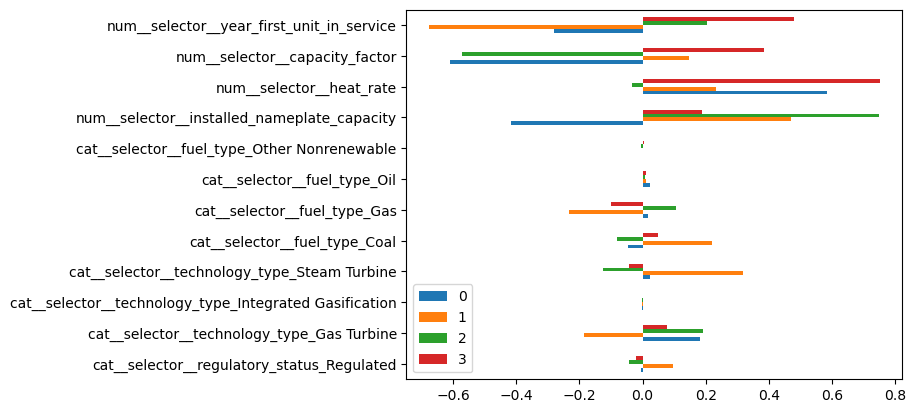

In [43]:
import numpy
dfComponents = pandas.DataFrame( numpy.transpose( pipePcaN[ 'model' ].components_ ) )
dfComponents.index = pipePcaN['preprocessor'].get_feature_names_out()
plot = dfComponents.plot.barh()
## this shows how each component is calculated